<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Global Market Profiles](Introduction.ipynb) › Most Volatile Countries
***

# Volatility

This notebook explores the relative volatity of different countries, above and below a given dollar volume threshold.

In [1]:
from quantrocket import get_prices
from quantrocket.account import download_exchange_rates
from quantrocket.master import get_securities_reindexed_like
import pandas as pd
import io

Get exchange rates (for converting non-USD stocks to USD dollar volume):

In [2]:
f = io.StringIO()
download_exchange_rates(f, latest=True, base_currencies="USD")
rates = pd.read_csv(f)
rates = rates.set_index("QuoteCurrency").Rate.to_dict()

In [3]:
def get_std(db, start_date, min_dollar_volume=0, max_dollar_volume=None, universes=None):
    """
    Returns the average standard dev of monthly, daily, overnight, and intraday returns from
    the start date until now. 
    """
    prices = get_prices(
        db, 
        start_date=start_date, 
        universes=universes, 
        fields=["Close","Open","Volume"])
        
    closes = prices.loc["Close"]
    opens = prices.loc["Open"]
    securities = get_securities_reindexed_like(closes, fields=["Currency","Multiplier","PriceMagnifier"])
    currencies = securities.loc["Currency"]
    multipliers = securities.loc["Multiplier"]
    magnifiers = securities.loc["PriceMagnifier"]
    volumes = prices.loc["Volume"]
    currencies = prices.loc["Currency"]
    multipliers = prices.loc["Multiplier"].reindex(closes.index, method="ffill")
    magnifiers = prices.loc["PriceMagnifier"].reindex(closes.index, method="ffill")
    exchange_rates = currencies.applymap(lambda x: rates[x])
    exchange_rates = exchange_rates.reindex(closes.index, method="ffill")
    closes = closes * multipliers.fillna(1) / magnifiers.fillna(1)
    opens = opens * multipliers.fillna(1) / magnifiers.fillna(1)
    dollar_volumes = closes.div(exchange_rates) * volumes
    avg_dollar_volumes = dollar_volumes.mean()
    sufficient_dollar_volumes = avg_dollar_volumes >= min_dollar_volume
    if max_dollar_volume:
        sufficient_dollar_volumes = sufficient_dollar_volumes & (avg_dollar_volumes <= max_dollar_volume)
    
    monthly_returns = (closes - closes.shift(22)) / closes.shift(22)
    monthly_returns = monthly_returns
    monthly_returns = monthly_returns.where((monthly_returns > -0.9) & (monthly_returns < 9), 0)
    monthly_std = monthly_returns.std()[sufficient_dollar_volumes].mean()
    
    cc_returns = closes.pct_change()
    # Ignore outliers
    cc_returns = cc_returns.where((cc_returns > -0.5) & (cc_returns < 1))
    cc_std = cc_returns.std()[sufficient_dollar_volumes].mean()
    
    co_returns = (opens - closes.shift()) / closes.shift()
    co_returns = co_returns.where((co_returns > -0.5) & (co_returns < 1))
    co_std = co_returns.std()[sufficient_dollar_volumes].mean()
    
    oc_returns = (closes - opens) / opens
    oc_returns = oc_returns.where((oc_returns > -0.5) & (oc_returns < 1))
    oc_std = oc_returns.std()[sufficient_dollar_volumes].mean()
    
    return {
        "monthly": monthly_std,
        "daily": cc_std,
        "intraday (open-to-close)": oc_std,
        "overnight (close-to-open)": co_std,
    }

In [4]:
def get_daily_std_by_year(db, years=[2015,2016,2017,2018], min_dollar_volume=0, max_dollar_volume=None, universes=None):
    """
    Returns the average daily standard deviation for each of the years.
    """
    all_years = {}
    for year in years:
        
        print(year)
        
        prices = get_prices(
            db, 
            start_date="{0}-01-01".format(year),
            end_date="{0}-12-31".format(year),
            universes=universes, 
            fields=["Close","Open","Volume"])
        
        closes = prices.loc["Close"]
        opens = prices.loc["Open"]

        volumes = prices.loc["Volume"]
        securities = get_securities_reindexed_like(closes, fields=["Currency","Multiplier","PriceMagnifier"])
        currencies = securities.loc["Currency"]
        multipliers = securities.loc["Multiplier"]
        magnifiers = securities.loc["PriceMagnifier"]
        exchange_rates = currencies.applymap(lambda x: rates[x])
        exchange_rates = exchange_rates.reindex(closes.index, method="ffill")
        closes = closes * multipliers.fillna(1) / magnifiers.fillna(1)
        opens = opens * multipliers.fillna(1) / magnifiers.fillna(1)
        dollar_volumes = closes.div(exchange_rates) * volumes
        avg_dollar_volumes = dollar_volumes.mean()
        sufficient_dollar_volumes = avg_dollar_volumes >= min_dollar_volume
        if max_dollar_volume:
            sufficient_dollar_volumes = sufficient_dollar_volumes & (avg_dollar_volumes <= max_dollar_volume)

        cc_returns = closes.pct_change()
        # Ignore outliers
        cc_returns = cc_returns.where((cc_returns > -0.5) & (cc_returns < 1))
        cc_std = cc_returns.std()[sufficient_dollar_volumes].mean()
        
        all_years[year] = cc_std
    
    return all_years

Countries for which numbers should be run:

In [5]:
countries = (
    # North America
    ("usa-stk-1d", "United States"),
    ("canada-stk-1d", "Canada"),
    ("mexico-stk-1d", "Mexico"),
    
    # Asia
    ("australia-stk-1d", "Australia"),
    ("japan-stk-1d", "Japan"),
    ("hongkong-stk-1d", "Hong Kong"),
    ("singapore-stk-1d", "Singapore"),
    
    # Europe
    ("spain-stk-1d", "Spain"),
    ("netherlands-stk-1d", "Netherlands"),
    ("uk-stk-1d", "United Kingdom"),
    ("germany-stk-1d", "Germany"),
    ("france-stk-1d", "France"),
    ("belgium-stk-1d", "Belgium"),
    ("swiss-stk-1d", "Switzerland"),
    ("austria-stk-1d", "Austria"),
    ("sweden-stk-1d", "Sweden"),
    ("italy-stk-1d", "Italy"),
)

Run numbers for each country:

In [5]:
volatilities = {}
start_date = "2018-01-01"

for db, country in countries:
    print(country)
    volatilities[country] = get_std(db, start_date)
    
volatilities = pd.DataFrame(volatilities).T * 100

United States
Canada
Mexico
Australia
Japan
Hong Kong
Singapore
Spain
Netherlands
United Kingdom
Germany
France
Belgium
Switzerland
Austria
Sweden
Italy


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(palette=sns.color_palette('deep', n_colors=3))

Text(0,0.5,'Standard deviation (%)')

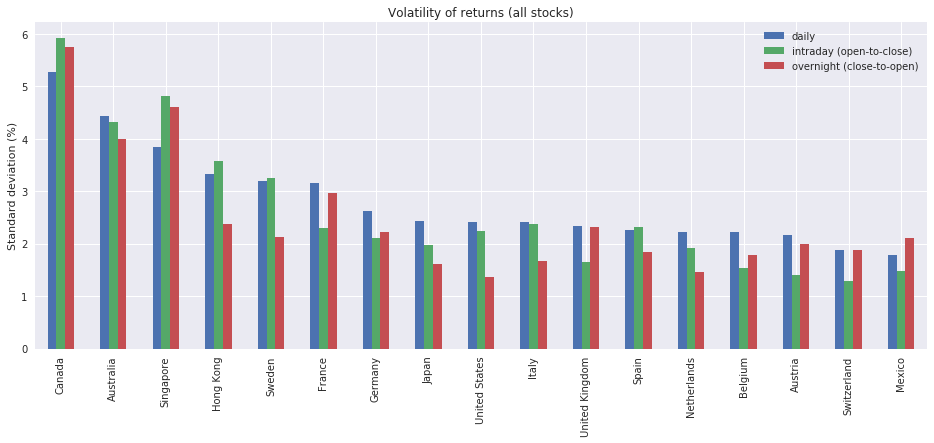

In [7]:
ax = volatilities.drop("monthly", axis=1).sort_values("daily", ascending=False).plot(kind="bar", title="Volatility of returns (all stocks)", figsize=(16,6))
ax.set_ylabel("Standard deviation (%)")

Repeat with a minimum dollar volume threshold of $1M USD:

In [8]:
volatilities = {}
start_date = "2018-01-01"

for db, country in countries:
    print(country)
    volatilities[country] = get_std(db, start_date, min_dollar_volume=1000000)
    
volatilities = pd.DataFrame(volatilities).T * 100

United States
Canada
Mexico
Australia
Japan
Hong Kong
Singapore
Spain
Netherlands
United Kingdom
Germany
France
Belgium
Switzerland
Austria
Sweden
Italy


Text(0,0.5,'Standard deviation (%)')

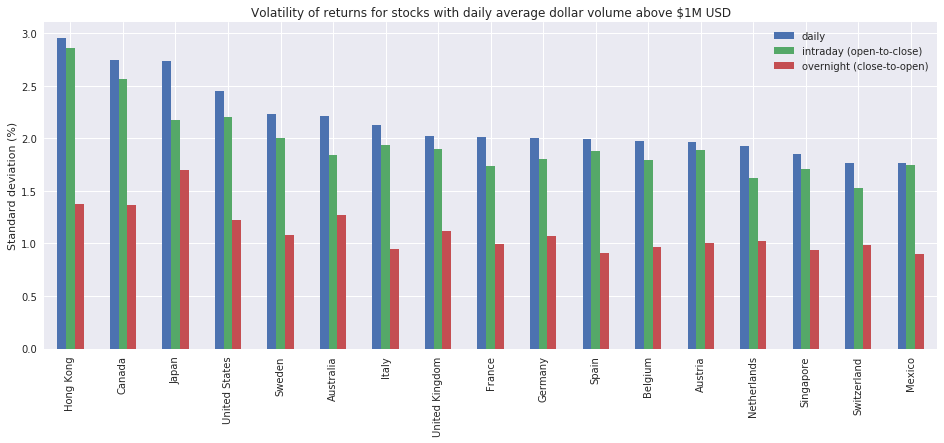

In [9]:
ax = volatilities.drop("monthly", axis=1).sort_values("daily", ascending=False).plot(kind="bar", title="Volatility of returns for stocks with daily average dollar volume above $1M USD", figsize=(16,6))
ax.set_ylabel("Standard deviation (%)")

Repeat with a maximum dollar volume threshold of $1M USD: 

In [10]:
volatilities = {}
start_date = "2018-01-01"

for db, country in countries:
    print(country)
    volatilities[country] = get_std(db, start_date, max_dollar_volume=1000000)
    
volatilities = pd.DataFrame(volatilities).T * 100

United States
Canada
Mexico
Australia
Japan
Hong Kong
Singapore
Spain
Netherlands
United Kingdom
Germany
France
Belgium
Switzerland
Austria
Sweden
Italy


Text(0,0.5,'Standard deviation (%)')

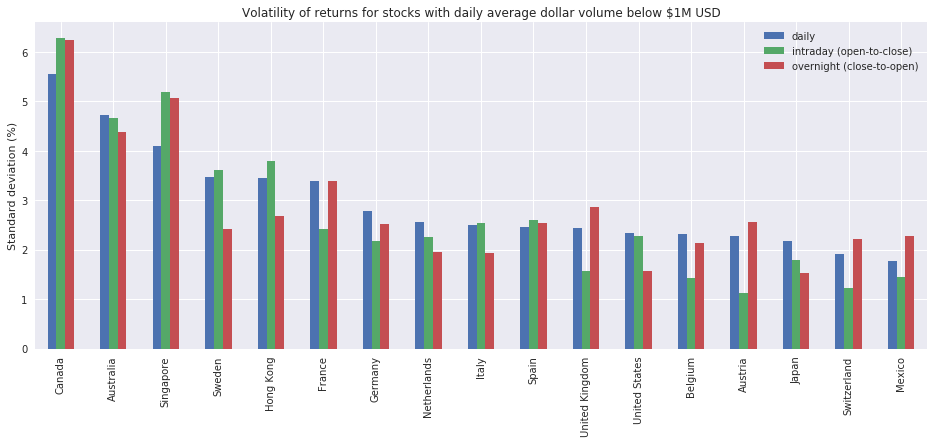

In [11]:
ax = volatilities.drop("monthly", axis=1).sort_values("daily", ascending=False).plot(kind="bar", title="Volatility of returns for stocks with daily average dollar volume below $1M USD", figsize=(16,6))
ax.set_ylabel("Standard deviation (%)")

In [6]:
volatilities = {}

for db, country in countries:
    print(country)
    volatilities[country] = get_daily_std_by_year(db, min_dollar_volume=1000000)
    
volatilities = pd.DataFrame(volatilities).T * 100

United States
2015
2016
2017
2018
Canada
2015
2016
2017
2018
Mexico
2015
2016
2017
2018
Australia
2015
2016
2017
2018
Japan
2015
2016
2017
2018
Hong Kong
2015
2016
2017
2018
Singapore
2015
2016
2017
2018
Spain
2015
2016
2017
2018
Netherlands
2015
2016
2017
2018
United Kingdom
2015
2016
2017
2018
Germany
2015
2016
2017
2018
France
2015
2016
2017
2018
Belgium
2015
2016
2017
2018
Switzerland
2015
2016
2017
2018
Austria
2015
2016
2017
2018
Sweden
2015
2016
2017
2018
Italy
2015
2016
2017
2018


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(palette=sns.color_palette('deep', n_colors=4))

Text(0,0.5,'Standard deviation (%)')

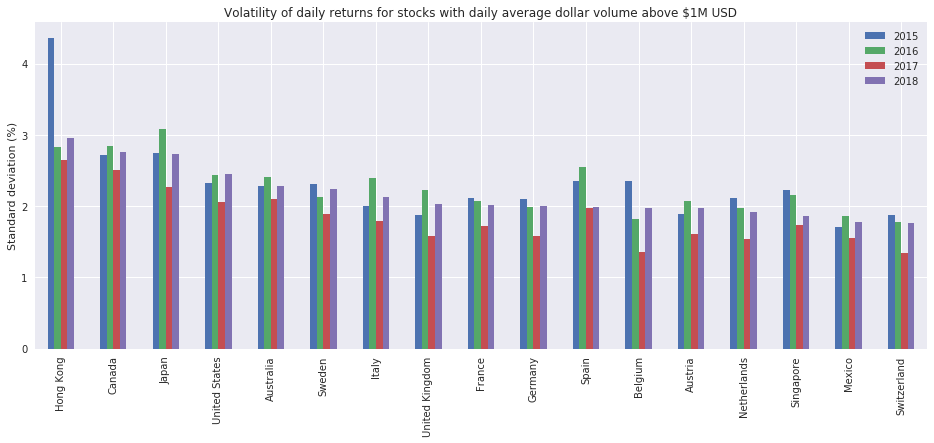

In [11]:
ax = volatilities.sort_values(2018, ascending=False).plot(kind="bar", title="Volatility of daily returns for stocks with daily average dollar volume above $1M USD", figsize=(16,6))
ax.set_ylabel("Standard deviation (%)")

In [24]:
# Get top 3 most volatile by year
volatilities.apply(lambda x: pd.Series(x.sort_values(ascending=False).head(3).index, index=["1st","2nd","3rd"]))

,2015,2016,2017,2018
1st,Hong Kong,Japan,Hong Kong,Hong Kong
2nd,Japan,Canada,Canada,Canada
3rd,Canada,Hong Kong,Japan,Japan


***

[Back to Introduction](Introduction.ipynb)